<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_7_%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B%E3%83%A2%E3%83%87%E3%83%AB_%E5%B0%A4%E5%BA%A6%E3%81%AE%E4%B8%80%E8%88%AC%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
# !pip install gpytorch==1.5.1
!pip install gpytorch
!pip install japanize-matplotlib

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

sns.set_context('talk', font_scale=0.8)

In [ ]:
import gpytorch
import torch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  


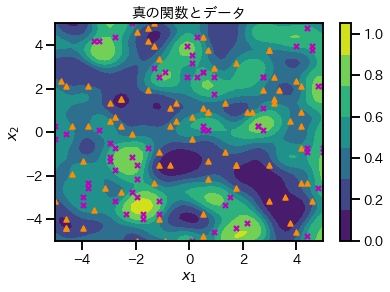

In [ ]:
np.random.seed(seed=3)

# 格子点数
grid_N = 50
# 2次元格子点作成
x = np.linspace(-5.0, 5.0, grid_N)
X1_grid, X2_grid = np.meshgrid(x, x)
X12_grid = np.array([[x1,x2] for x1, x2 in zip(X1_grid.ravel(), X2_grid.ravel())])
X12_grid = torch.from_numpy(X12_grid).float()

# ガウス過程でデータ生成
kernel = gpytorch.kernels.RBFKernel()
K = kernel.forward(X12_grid, X12_grid).detach().numpy()
f = np.random.multivariate_normal(mean=np.zeros(grid_N**2), cov=K)

# シグモイド関数
sigmoid = lambda x: 1/(1+np.exp(-x))
Y =  sigmoid(f)
Y_grid =Y.reshape(grid_N, grid_N)

# 閾値で二値化
threshhold = lambda x : 1 if x>=0.5 else 0
Y_binary_grid = torch.tensor(list(map(threshhold, Y)))

# 学習用にデータをサンプリング
N = 150
np.random.seed(seed=1)
sample_index = np.random.choice(np.arange(grid_N**2), N)
x_data = X12_grid[sample_index].clone().float()
y_data = Y_binary_grid[sample_index].clone().float()

fig, ax = plt.subplots(figsize=(6, 4))
image = ax.contourf(X1_grid, X2_grid, Y_grid)

# データ点をプロット
x_data_1 = x_data[y_data==0]
x_data_2 = x_data[y_data==1]
ax.scatter(x=x_data_1[:,0], y=x_data_1[:,1], color='darkorange', marker='^',label='setosa', s =25)
ax.scatter(x=x_data_2[:,0], y=x_data_2[:,1], color='m', marker='x', label='vesicolor', s =25)

c_ticks = np.arange(0, 1.2, 0.2)
pp = fig.colorbar(image, ticks=c_ticks)
ax.set_title('真の関数とデータ');
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy

# ガウス過程回帰モデル
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        # 平均関数
        self.mean_module = gpytorch.means.ConstantMean()
        # カーネル関数
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(2))
        
    # ガウス過程の生成過程
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

# モデルをインスタンス化
model = GPClassificationModel(x_data)
# 尤度にベルヌーイ分布を設定
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [ ]:
# 学習モードに設定
model.train()
likelihood.train()

# RBFカーネルのパラメータを固定する
model.covar_module.base_kernel.lengthscale=torch.tensor([0.6931, 0.6931])
# 最適化対象
all_params = set(model.parameters())
fix_params =  {model.covar_module.base_kernel.raw_lengthscale}
opt_params = list(all_params - fix_params)

optimizer = torch.optim.Adam(opt_params, lr=0.1)

# 周辺対数尤度の計算
mll = gpytorch.mlls.VariationalELBO(likelihood, model, y_data.numel())

training_iter = 200
loss_list = []
for i in range(training_iter):
    # 勾配を0に初期化
    optimizer.zero_grad()
    # モデルからの出力
    output = model(x_data)
    # 損失関数の計算
    loss = -mll(output, y_data)
    # 勾配計算
    loss.backward()
    loss_list.append(loss.item())
    # パラメータ計算
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


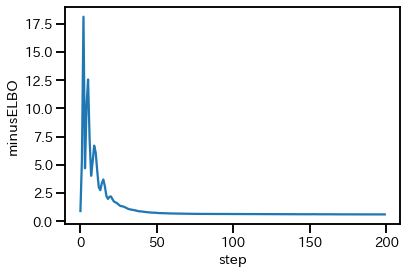

In [ ]:
plt.plot(loss_list)
plt.xlabel('step')
plt.ylabel('minusELBO');

In [ ]:
# 推論モードに設定
model.eval()
likelihood.eval()

with torch.no_grad():
    # 予測分布の出力
    f_dist = model(X12_grid)
    # 予測分布の平均
    mean = f_dist.mean
    # 信頼区間の出力
    f_lower, f_upper = f_dist.confidence_region()
    # 尤度にのパラメータとして入力
    y_dist = likelihood(f_dist)

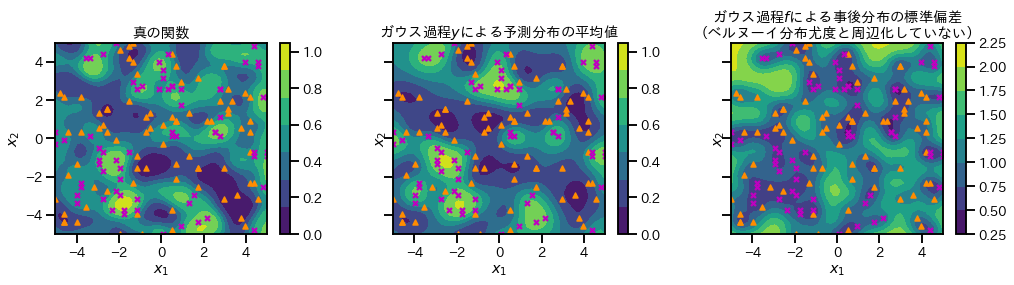

In [ ]:
fig, ax = plt.subplots(figsize=(12*1.2, 3.5*1.2), ncols=3, sharex=True, sharey=True)
# 真の関数の等高線図
image1 = ax[0].contourf(X1_grid, X2_grid, Y_grid)
# 予測分布平均の等高線図
image2 = ax[1].contourf(X1_grid, X2_grid, y_dist.mean.numpy().reshape(grid_N, grid_N))
# 予測分布共分散行列の対角要素の等高線図
image3 = ax[2].contourf(X1_grid, X2_grid, f_dist.covariance_matrix.diag().detach().numpy().reshape(grid_N, grid_N))

for i in range(3):
  ax[i].scatter(x=x_data_1[:,0], y=x_data_1[:,1], color='darkorange', marker='^',label='setosa', s =25)
  ax[i].scatter(x=x_data_2[:,0], y=x_data_2[:,1], color='m', marker='x', label='vesicolor', s =25)


ax[0].set_title('真の関数')
ax[1].set_title('ガウス過程$y$による予測分布の平均値')
ax[2].set_title('ガウス過程$f$による事後分布の標準偏差\n（ベルヌーイ分布尤度と周辺化していない）')

for i in range(3):
  ax[i].set_xlabel('$x_1$')
  ax[i].set_ylabel('$x_2$')
#plt.colorbar(image1,ax=ax[0]);plt.colorbar(image2,ax=ax[1]);plt.colorbar(image3,ax=ax[2])
fig.colorbar(image1, ticks= np.arange(0, 1.2, 0.2),ax=ax[0])
fig.colorbar(image2, ticks= np.arange(0, 1.2, 0.2),ax=ax[1])
fig.colorbar(image3, ax=ax[2])

plt.tight_layout();

In [ ]:
%load_ext watermark
%watermark --iversions

numpy              : 1.21.6
japanize_matplotlib: 1.1.3
IPython            : 5.5.0
seaborn            : 0.11.2
scipy              : 1.4.1
pandas             : 1.3.5
matplotlib         : 3.2.2
gpytorch           : 1.6.0
torch              : 1.11.0+cu113
arviz              : 0.12.1

